In [6]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import statistics
pd.set_option('display.max_columns', None)
from statistics import mode


In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)

if response.status_code == 200:
    print('Success!')
elif response.status_code == 404:
    print('Not Found.')
    
print(url)
print(response.headers)

Success!
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
{'Date': 'Sat, 10 Aug 2019 20:22:00 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '15022', 'Connection': 'keep-alive', 'Server': 'mw1239.eqiad.wmnet', 'X-Content-Type-Options': 'nosniff', 'P3P': 'CP="This is not a P3P policy! See https://en.wikipedia.org/wiki/Special:CentralAutoLogin/P3P for more info."', 'X-Powered-By': 'HHVM/3.18.6-dev', 'Content-language': 'en', 'Last-Modified': 'Sat, 27 Jul 2019 12:27:11 GMT', 'Backend-Timing': 'D=106608 t=1565440031655601', 'Vary': 'Accept-Encoding,Cookie,Authorization,X-Seven', 'Content-Encoding': 'gzip', 'X-Varnish': '958596207 521479525, 694289174 635976599', 'Age': '28488', 'X-Cache': 'cp1081 hit/6, cp1075 hit/1', 'X-Cache-Status': 'hit-front', 'Server-Timing': 'cache;desc="hit-front"', 'Strict-Transport-Security': 'max-age=106384710; includeSubDomains; preload', 'Set-Cookie': 'WMF-Last-Access=10-Aug-2019;Path=/;HttpOnly;secure;Expires=Wed, 11 Sep 20

In [8]:
soup = BeautifulSoup(response.text, 'lxml')
table_body=soup.find('tbody')
trs = table_body.find_all('tr')
rows = []
for tr in trs:
    i = tr.find_all('td')
    if i:
        rows.append(i)

In [9]:
list_table = []
for row in rows:
    postalcode = row[0].text.strip()
    borough = row[1].text.strip()
    neighborhood = row[2].text.strip()
    if borough != 'Not assigned':             
        if neighborhood == 'Not assigned':
            neighborhood = borough
        list_table.append([postalcode, borough, neighborhood])

In [10]:
df = pd.DataFrame(list_table, columns=['PostalCode', 'Borough', 'Neighborhood'])
print(df.shape)

(211, 3)


In [11]:
#Drops rows where Borough = 'Not assigned' if any
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)


In [12]:
df = df.groupby('PostalCode').agg({'Borough':'first','Neighborhood': ', '.join}).reset_index()

In [13]:
df.loc[df['PostalCode'] == 'M5A']

,PostalCode,Borough,Neighborhood
53,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [14]:
df.shape

(103, 3)

In [15]:
loc_df = pd.read_csv('http://cocl.us/Geospatial_data')

In [16]:
loc_df.rename(columns={'Postal Code':'PostalCode'},inplace = True)

In [17]:
df2 = pd.merge(df, loc_df, on="PostalCode", how='left')


In [18]:
#Toronto Coordinates
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [20]:
CLIENT_ID = '23QCEME0X05NQPDAGB1K0WYP3PRWCIJ0ALLDPMBEY1ZXTZPG' # Foursquare ID
CLIENT_SECRET = 'A5YTYTWO5L2D11VOQDEDD3U5YJI1PNQ4C4XPSTVQEU3SHWYV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 23QCEME0X05NQPDAGB1K0WYP3PRWCIJ0ALLDPMBEY1ZXTZPG
CLIENT_SECRET:A5YTYTWO5L2D11VOQDEDD3U5YJI1PNQ4C4XPSTVQEU3SHWYV


In [21]:
#Exploring the Woburn Neighborhood
df2.loc[3, 'Neighborhood']

'Woburn'

In [22]:
neighborhood_latitude = df2.loc[3, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[3, 'Longitude'] # neighborhood longitude value

neighborhood_name = df2.loc[3, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Woburn are 43.7709921, -79.21691740000001.


In [23]:
#Getting the top 100 venues that are in Woburn within a radius of 500 meters.

In [24]:
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [25]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d4f2772075a4200314096ae'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.7754921045, 'lng': -79.21069729639068},
   'sw': {'lat': 43.7664920955, 'lng': -79.22313750360935}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cc1d28c06c254815ac18547',
       'name': 'Starbucks',
       'location': {'address': '300 Borough Dr',
        'crossStreet': 'Scarborough Town Centre',
        'lat': 43.770037201625215,
        'lng': -79.22115586641958,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.770037201625215,
          'lng': -79.22115586641958}],
        'distance': 356,
        'cc': 'CA

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.770037,-79.221156
1,Tim Hortons,Coffee Shop,43.770827,-79.223078
2,Korean Grill House,Korean Restaurant,43.770812,-79.214502
3,Rexall Pharma Plus,Pharmacy,43.772778,-79.222500


In [28]:
#Looking at all Neighborhoods in Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
toronto_venues= getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude'])


Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [30]:
##Analyzing all the Toronto Neighborhoods
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
post1 = []
for col in toronto_onehot.columns:
    if ('Restaurant') in col:
        post1.append(col)


toronto_onehot['Total_Restaurant']=0

for i in post1:
    toronto_onehot['Total_Restaurant'] += toronto_onehot[i]






In [32]:
toronto_onehot['Total_Restaurant'].sum()

524

In [33]:
toronto_onehot2=toronto_onehot[['Total_Restaurant','Neighborhood']]

In [34]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped1 = toronto_onehot2.groupby('Neighborhood').agg({'Total_Restaurant':np.mean}).reset_index()
toronto_grouped2 = toronto_onehot2.groupby('Neighborhood').agg({'Total_Restaurant':np.sum}).reset_index()
toronto_grouped1 = toronto_grouped1.sort_values(by='Total_Restaurant', ascending=False)
toronto_grouped1['Total_Restaurant_Frequency']=toronto_grouped1['Total_Restaurant']
toronto_grouped1 = toronto_grouped1.drop(columns=['Total_Restaurant'])
toronto_grouped_final= toronto_grouped1.join(toronto_grouped2.set_index('Neighborhood'), on='Neighborhood')
toronto_grouped_final.head()

,Neighborhood,Total_Restaurant_Frequency,Total_Restaurant
76,"Rouge, Malvern",1.000000,1
34,"Dorset Park, Scarborough Town Centre, Wexford ...",0.833333,5
25,"Cliffcrest, Cliffside, Scarborough Village West",0.500000,1
6,Bayview Village,0.500000,2
57,Humber Summit,0.500000,1


In [35]:
toronto_merged = df2


toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [36]:
toronto_merged_final = toronto_merged.join(toronto_grouped_final.set_index('Neighborhood'), on='Neighborhood')
toronto_merged_final=toronto_merged_final[['Borough','Neighborhood','PostalCode','Latitude','Longitude','Total_Restaurant','Total_Restaurant_Frequency']]
toronto_merged_final=toronto_merged_final.sort_values(by='Total_Restaurant', ascending=False)

In [37]:
toronto_merged_final.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000
61,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,27.0,0.270000
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000


In [38]:
toronto_merged_final=toronto_merged_final[['Borough','Neighborhood','PostalCode','Latitude','Longitude','Total_Restaurant','Total_Restaurant_Frequency']]
toronto_merged_final=toronto_merged_final.sort_values(by='Total_Restaurant', ascending=False)

In [39]:
lat_group=list(toronto_merged_final['Latitude'])
lat_list=list(map(str, lat_group))
lon_group=list(toronto_merged_final['Longitude'])
lon_list = list(map(str, lon_group))

In [40]:
#Obtaining AVG Temperature List
lst_temp=[]
final_lst_temp=[]

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        temp_data=json_data['list'][i]['main']['temp']
        lst_temp.append(temp_data)
    temp_avg=statistics.mean(lst_temp)
    final_lst_temp.append(temp_avg)

final_lst_temp[0:5]

[63.04025, 63.03, 63.02891666666667, 63.028375000000004, 63.02805]

In [41]:
#Obtaining AVG Humidity List
lst_hum=[]
final_lst_hum=[]

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        hum_data=json_data['list'][i]['main']['humidity']
        lst_hum.append(hum_data)
    hum_avg=statistics.mean(lst_hum)
    final_lst_hum.append(hum_avg)

final_lst_hum[0:5]

[75.5, 75.5, 75.5, 75.5, 75.5]

In [42]:
final_np_temp = np.asarray(final_lst_temp)

In [43]:
final_np_hum=np.asarray(final_lst_hum)

In [44]:
toronto_merged_final['Average 5-Day Temperature']= final_np_temp

In [45]:
toronto_merged_final['Average 5-Day Humidity'] = final_np_hum

In [46]:
toronto_merged_final.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency,Average 5-Day Temperature,Average 5-Day Humidity
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000,63.040250,75.5
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659,63.030000,75.5
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000,63.028917,75.5
61,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,27.0,0.270000,63.028375,75.5
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000,63.028050,75.5


In [47]:
json_data['list'][i]['weather'][0]['description']

'clear sky'

In [48]:
#Obtaining most frequent weather condition
lst_con=[]
final_lst_con=[]
from collections import Counter

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        con_data=json_data['list'][i]['weather'][0]['description']
        lst_con.append(con_data)
        c = Counter(lst_con)
        common_list = c.most_common(i)
        
    if common_list[0][1] > common_list[1][1]:
        final_lst_con.append(common_list[0][0])
    elif common_list[0][1] == common_list[1][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1]==common_list[3][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0]+' & '+ common_list[4][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[2][0] +' & '+ common_list[3][0]+' & '+ common_list[4][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1] == common_list[5][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1] == common_list[5][1] == common_list[6][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0] +' & '+ common_list[7][0]


In [49]:
len(final_lst_con)

103

In [50]:
final_np_con = np.asarray(final_lst_con)

In [51]:
toronto_merged_final['Most Frequent Weather Condition']= final_np_con

In [52]:
toronto_merged_final.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000,63.040250,75.5,clear sky
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659,63.030000,75.5,clear sky
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000,63.028917,75.5,clear sky
61,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,27.0,0.270000,63.028375,75.5,clear sky
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000,63.028050,75.5,clear sky


In [53]:
#Frequency of Clear Sky Condition

lst_con2=[]
final_lst_con2=[]
from collections import Counter

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        con_data=json_data['list'][i]['weather'][0]['description']
        lst_con2.append(con_data)
    lst_con2_count = lst_con2.count('clear sky')/40
    final_lst_con2.append(lst_con2_count)
    lst_con2=[]

In [54]:
len(final_lst_con2)

103

In [55]:
final_np_con2 = np.asarray(final_lst_con2)

In [56]:
toronto_merged_final['Clear Sky condition frequency']= final_np_con2

In [57]:
toronto_merged_final.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition,Clear Sky condition frequency
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000,63.040250,75.5,clear sky,0.55
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659,63.030000,75.5,clear sky,0.55
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000,63.028917,75.5,clear sky,0.55
61,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,27.0,0.270000,63.028375,75.5,clear sky,0.55
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000,63.028050,75.5,clear sky,0.55


In [58]:
### New York

In [59]:
import numpy as np # library to handle data in a vectorized manner
import wget
import json

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [60]:
import os
os.chdir('/Users/Jeffrey.Lu@ibm.com/Desktop')

In [61]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [62]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [63]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [64]:
neighborhoods_data = newyork_data['features']

In [65]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [66]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [67]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [68]:
#Making sure we have 5 boroughs in the data set
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [69]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [70]:
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [71]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d4f27ce0d2be7002ce10a3b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 11,
  'suggestedBounds': {'ne': {'lat': 40.899205181110005,
    'lng': -73.84125857127495},
   'sw': {'lat': 40.89020517211, 'lng': -73.8531424698231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeledLatL

In [72]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [73]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,40.898276,-73.850381
4,Dunkin',Donut Shop,40.890459,-73.849089


In [74]:
newyork_data = neighborhoods
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [75]:
#Looking at all Neighborhoods in New York

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
newyork_venues = getNearbyVenues(names=newyork_data['Neighborhood'],
                                   latitudes=newyork_data['Latitude'],
                                   longitudes=newyork_data['Longitude'])



Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [77]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great

In [78]:
post2 = []
for col in newyork_onehot.columns:
    if ('Restaurant') in col:
        post2.append(col)




In [79]:
newyork_onehot['Total_Restaurant']=0

for i in post2:
    newyork_onehot['Total_Restaurant'] += newyork_onehot[i]
    

In [80]:
newyork_onehot['Total_Restaurant'].sum()

2593

In [81]:
newyork_onehot2=newyork_onehot[['Total_Restaurant','Neighborhood']]

In [82]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
newyork_grouped1 = newyork_onehot2.groupby('Neighborhood').agg({'Total_Restaurant':np.mean}).reset_index()
newyork_grouped2 = newyork_onehot2.groupby('Neighborhood').agg({'Total_Restaurant':np.sum}).reset_index()
newyork_grouped1 = newyork_grouped1.sort_values(by='Total_Restaurant', ascending=False)
newyork_grouped1['Total_Restaurant_Frequency']=newyork_grouped1['Total_Restaurant']
newyork_grouped1 = newyork_grouped1.drop(columns=['Total_Restaurant'])
newyork_grouped_final= newyork_grouped1.join(newyork_grouped2.set_index('Neighborhood'), on='Neighborhood')
newyork_grouped_final.head()

,Neighborhood,Total_Restaurant_Frequency,Total_Restaurant
89,Elmhurst,0.690476,29
222,Ravenswood,0.535714,15
42,Canarsie,0.500000,4
98,Floral Park,0.500000,4
138,Jackson Heights,0.469136,38


In [83]:
newyork_merged = newyork_data


newyork_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [84]:
newyork_merged_final = newyork_merged.join(newyork_grouped_final.set_index('Neighborhood'), on='Neighborhood')
newyork_merged_final= newyork_merged_final.sort_values(by='Total_Restaurant', ascending=False)
newyork_merged_final



,Borough,Neighborhood,Latitude,Longitude,Total_Restaurant_Frequency,Total_Restaurant
115,Manhattan,Murray Hill,40.748303,-73.978332,0.390411,57.0
180,Queens,Murray Hill,40.764126,-73.812763,0.390411,57.0
117,Manhattan,Greenwich Village,40.726933,-73.999914,0.440000,44.0
100,Manhattan,Chinatown,40.715618,-73.994279,0.420000,42.0
273,Manhattan,Turtle Bay,40.752042,-73.967708,0.400000,40.0
118,Manhattan,East Village,40.727847,-73.982226,0.390000,39.0
131,Queens,Jackson Heights,40.751981,-73.882821,0.469136,38.0
84,Brooklyn,Clinton Hill,40.693229,-73.967843,0.400000,36.0
277,Queens,Sunnyside Gardens,40.745652,-73.918193,0.350000,35.0
111,Manhattan,Upper West Side,40.787658,-73.977059,0.350000,35.0


In [85]:
lat_group=list(newyork_merged_final['Latitude'])
lat_list=list(map(str, lat_group))
lon_group=list(newyork_merged_final['Longitude'])
lon_list = list(map(str, lon_group))

In [86]:
#Obtaining AVG Temperature List
lst_temp=[]
final_lst_temp=[]

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        temp_data=json_data['list'][i]['main']['temp']
        lst_temp.append(temp_data)
    temp_avg=statistics.mean(lst_temp)
    final_lst_temp.append(temp_avg)

final_lst_temp[0:5]

[75.71975, 75.723625, 73.24091666666666, 73.8603125, 74.23185]

In [87]:
#Obtaining AVG Humidity List
lst_hum=[]
final_lst_hum=[]

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        hum_data=json_data['list'][i]['main']['humidity']
        lst_hum.append(hum_data)
    hum_avg=statistics.mean(lst_hum)
    final_lst_hum.append(hum_avg)

final_lst_hum[0:5]

[51.95, 51.95, 58.84166666666667, 57.11875, 56.085]

In [88]:
final_np_temp = np.asarray(final_lst_temp)

In [89]:
final_np_hum=np.asarray(final_lst_hum)

In [90]:
newyork_merged_final['Average 5-Day Temperature']= final_np_temp

In [91]:
newyork_merged_final['Average 5-Day Humidity'] = final_np_hum

In [92]:
newyork_merged_final.head()

,Borough,Neighborhood,Latitude,Longitude,Total_Restaurant_Frequency,Total_Restaurant,Average 5-Day Temperature,Average 5-Day Humidity
115,Manhattan,Murray Hill,40.748303,-73.978332,0.390411,57.0,75.719750,51.950000
180,Queens,Murray Hill,40.764126,-73.812763,0.390411,57.0,75.723625,51.950000
117,Manhattan,Greenwich Village,40.726933,-73.999914,0.440000,44.0,73.240917,58.841667
100,Manhattan,Chinatown,40.715618,-73.994279,0.420000,42.0,73.860313,57.118750
273,Manhattan,Turtle Bay,40.752042,-73.967708,0.400000,40.0,74.231850,56.085000


In [93]:
json_data['list'][i]['weather'][0]['description']

'scattered clouds'

In [94]:
#Obtaining most frequent weather condition
lst_con=[]
final_lst_con=[]
from collections import Counter

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        con_data=json_data['list'][i]['weather'][0]['description']
        lst_con.append(con_data)
        c = Counter(lst_con)
        common_list = c.most_common(i)
        
    if common_list[0][1] > common_list[1][1]:
        final_lst_con.append(common_list[0][0])
    elif common_list[0][1] == common_list[1][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1]==common_list[3][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0]+' & '+ common_list[4][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[2][0] +' & '+ common_list[3][0]+' & '+ common_list[4][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1] == common_list[5][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0])
    elif common_list[0][1] == common_list[1][1] == common_list[2][1] == common_list[3][1] == common_list[4][1] == common_list[5][1] == common_list[5][1] == common_list[6][1]:
        final_lst_con.append(common_list[0][0] +' & '+ common_list[1][0] +' & '+ common_list[3][0] +' & '+ common_list[4][0] +' & '+ common_list[5][0] +' & '+ common_list[6][0] +' & '+ common_list[7][0])
      
        


In [95]:
len(final_lst_con)

306

In [96]:
final_np_con = np.asarray(final_lst_con)

In [97]:
newyork_merged_final['Most Frequent Weather Condition']= final_np_con

In [98]:
newyork_merged_final.head()

,Borough,Neighborhood,Latitude,Longitude,Total_Restaurant_Frequency,Total_Restaurant,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition
115,Manhattan,Murray Hill,40.748303,-73.978332,0.390411,57.0,75.719750,51.950000,clear sky
180,Queens,Murray Hill,40.764126,-73.812763,0.390411,57.0,75.723625,51.950000,clear sky
117,Manhattan,Greenwich Village,40.726933,-73.999914,0.440000,44.0,73.240917,58.841667,clear sky
100,Manhattan,Chinatown,40.715618,-73.994279,0.420000,42.0,73.860313,57.118750,clear sky
273,Manhattan,Turtle Bay,40.752042,-73.967708,0.400000,40.0,74.231850,56.085000,clear sky


In [99]:
#Frequency of Clear Sky Condition

lst_con2=[]
final_lst_con2=[]
from collections import Counter

for lat, lon in zip(lat_list, lon_list):
    api_address='http://api.openweathermap.org/data/2.5/forecast?lat='+lat+'&lon='+lon+'&units=imperial&APPID=aee82abb5cd39bd3aef65599bde034fa'
    json_data= requests.get(api_address).json()
    
    for i in range(0,40):
        con_data=json_data['list'][i]['weather'][0]['description']
        lst_con2.append(con_data)
    lst_con2_count = lst_con2.count('clear sky')/40
    final_lst_con2.append(lst_con2_count)
    lst_con2=[]

In [100]:
len(final_lst_con2)

306

In [101]:
final_np_con2 = np.asarray(final_lst_con2)

In [102]:
newyork_merged_final['Clear Sky condition frequency']= final_np_con2

In [103]:
newyork_merged_final.head()

,Borough,Neighborhood,Latitude,Longitude,Total_Restaurant_Frequency,Total_Restaurant,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition,Clear Sky condition frequency
115,Manhattan,Murray Hill,40.748303,-73.978332,0.390411,57.0,75.719750,51.950000,clear sky,0.375
180,Queens,Murray Hill,40.764126,-73.812763,0.390411,57.0,75.723625,51.950000,clear sky,0.375
117,Manhattan,Greenwich Village,40.726933,-73.999914,0.440000,44.0,73.240917,58.841667,clear sky,0.375
100,Manhattan,Chinatown,40.715618,-73.994279,0.420000,42.0,73.860313,57.118750,clear sky,0.375
273,Manhattan,Turtle Bay,40.752042,-73.967708,0.400000,40.0,74.231850,56.085000,clear sky,0.375


In [104]:
## Combining Both Toronto and New York Datasets

In [105]:
df=toronto_merged_final.append(newyork_merged_final)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [106]:
df.drop('PostalCode', axis = 1, inplace= True)

In [107]:
df

,Average 5-Day Humidity,Average 5-Day Temperature,Borough,Clear Sky condition frequency,Latitude,Longitude,Most Frequent Weather Condition,Neighborhood,Total_Restaurant,Total_Restaurant_Frequency
67,75.500000,63.040250,Downtown Toronto,0.550,43.653206,-79.400049,clear sky,"Chinatown, Grange Park, Kensington Market",33.0,0.330000
52,75.500000,63.030000,Downtown Toronto,0.550,43.665860,-79.383160,clear sky,Church and Wellesley,29.0,0.353659
58,75.500000,63.028917,Downtown Toronto,0.550,43.650571,-79.384568,clear sky,"Adelaide, King, Richmond",28.0,0.280000
61,75.500000,63.028375,Downtown Toronto,0.550,43.648198,-79.379817,clear sky,"Commerce Court, Victoria Hotel",27.0,0.270000
55,75.500000,63.028050,Downtown Toronto,0.550,43.651494,-79.375418,clear sky,St. James Town,27.0,0.270000
70,75.500000,63.027833,Downtown Toronto,0.550,43.648429,-79.382280,clear sky,"First Canadian Place, Underground city",27.0,0.270000
57,75.500000,63.026536,Downtown Toronto,0.550,43.657952,-79.387383,clear sky,Central Bay Street,24.0,0.292683
54,75.500000,63.028813,Downtown Toronto,0.550,43.657162,-79.378937,clear sky,"Ryerson, Garden District",23.0,0.230000
60,75.500000,63.028583,Downtown Toronto,0.550,43.647177,-79.381576,clear sky,"Design Exchange, Toronto Dominion Centre",23.0,0.230000
69,75.500000,63.028400,Downtown Toronto,0.550,43.646435,-79.374846,clear sky,Stn A PO Boxes 25 The Esplanade,20.0,0.208333


In [108]:
### Analyzing Neighborhoods in Toronto and New York with Clustering

In [109]:
newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great

In [110]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped.drop('Total_Restaurant', axis = 1, inplace = True)

In [111]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
            venue  freq
0     Pizza Place  0.15
1     Supermarket  0.07
2             Spa  0.07
3   Deli / Bodega  0.07
4  Discount Store  0.04


----Annadale----
           venue  freq
0   Dance Studio   0.1
1     Sports Bar   0.1
2    Pizza Place   0.1
3         Bakery   0.1
4  Train Station   0.1


----Arden Heights----
         venue  freq
0     Pharmacy  0.25
1  Pizza Place  0.25
2  Coffee Shop  0.25
3     Bus Stop  0.25
4  Yoga Studio  0.00


----Arlington----
                 venue  freq
0        Deli / Bodega  0.17
1          Coffee Shop  0.17
2             Bus Stop  0.17
3  American Restaurant  0.17
4         Intersection  0.17


----Arrochar----
                venue  freq
0       Deli / Bodega  0.15
1            Bus Stop  0.10
2          Bagel Shop  0.10
3  Italian Restaurant  0.10
4          Food Truck  0.05


----Arverne----
            venue  freq
0       Surf Spot  0.22
1  Sandwich Place  0.11
2   Metro Station  0.11
3     Coffee Shop  0.06
4      Board 

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Spa,Supermarket,Dessert Shop,Bakery,Martial Arts Dojo,Intersection,Gas Station,Spanish Restaurant
1,Annadale,Dance Studio,Food,Pizza Place,Restaurant,Bakery,Sports Bar,American Restaurant,Train Station,Park,Diner
2,Arden Heights,Coffee Shop,Bus Stop,Pizza Place,Pharmacy,Women's Store,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,Farm
3,Arlington,Grocery Store,Deli / Bodega,Intersection,American Restaurant,Coffee Shop,Bus Stop,Women's Store,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Deli / Bodega,Italian Restaurant,Bus Stop,Bagel Shop,Polish Restaurant,Pizza Place,Sandwich Place,Athletics & Sports,Mediterranean Restaurant,Hotel


In [114]:
# set number of clusters
kclusters = 10

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 0, 6, 7, 7, 0, 0, 0, 0, 0], dtype=int32)

In [115]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = newyork_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!



,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,9.0,Sandwich Place,Laundromat,Pharmacy,Food Truck,Dessert Shop,Gas Station,Donut Shop,Pizza Place,Food,Ice Cream Shop
1,Bronx,Co-op City,40.874294,-73.829939,2.0,Baseball Field,Bus Station,Pharmacy,Ice Cream Shop,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Chinese Restaurant,Mattress Store
2,Bronx,Eastchester,40.887556,-73.827806,9.0,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Bus Station,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,0.0,River,Playground,Plaza,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Park,Plaza,Bank,Bus Station,Food Truck,Locksmith,Home Service,Gym,Playground,Women's Store


In [116]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels'].fillna(0)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [117]:
newyork_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,9.0,Sandwich Place,Laundromat,Pharmacy,Food Truck,Dessert Shop,Gas Station,Donut Shop,Pizza Place,Food,Ice Cream Shop
1,Bronx,Co-op City,40.874294,-73.829939,2.0,Baseball Field,Bus Station,Pharmacy,Ice Cream Shop,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Chinese Restaurant,Mattress Store
2,Bronx,Eastchester,40.887556,-73.827806,9.0,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Bus Station,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,0.0,River,Playground,Plaza,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Park,Plaza,Bank,Bus Station,Food Truck,Locksmith,Home Service,Gym,Playground,Women's Store


In [118]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,River,Playground,Plaza,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
6,Marble Hill,Sandwich Place,Coffee Shop,Discount Store,Yoga Studio,Pizza Place,Steakhouse,Spa,Supplement Shop,Gym,Tennis Stadium
12,City Island,Harbor / Marina,Ice Cream Shop,Seafood Restaurant,Thrift / Vintage Store,Spanish Restaurant,Music Venue,Italian Restaurant,French Restaurant,Park,Baseball Field
22,Port Morris,Cupcake Shop,Latin American Restaurant,Deli / Bodega,Restaurant,Distillery,Donut Shop,Peruvian Restaurant,Spanish Restaurant,Food Truck,Furniture / Home Store
24,Hunts Point,Bakery,Spanish Restaurant,Gourmet Shop,BBQ Joint,Farmers Market,Food,Café,Grocery Store,Pizza Place,Restaurant
35,Spuyten Duyvil,Asian Restaurant,Intersection,Pharmacy,Bank,Thai Restaurant,Tennis Stadium,Tennis Court,Park,Women's Store,Factory
37,Pelham Bay,Fast Food Restaurant,Bank,Italian Restaurant,Spa,Sandwich Place,Convenience Store,Donut Shop,Cosmetics Shop,Gym / Fitness Center,Chinese Restaurant
46,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Bagel Shop,American Restaurant,Grocery Store,Bar,Greek Restaurant,Hookah Bar,Chinese Restaurant
47,Bensonhurst,Donut Shop,Sushi Restaurant,Ice Cream Shop,Chinese Restaurant,Deli / Bodega,Grocery Store,Bakery,Pet Store,Coffee Shop,Shabu-Shabu Restaurant
49,Greenpoint,Bar,Coffee Shop,Cocktail Bar,Pizza Place,Yoga Studio,Mexican Restaurant,French Restaurant,Café,Boutique,Record Shop


In [119]:
newyork_merged['Borough-Neighborhood']= list(zip(newyork_merged['Borough'], newyork_merged['Neighborhood']))

In [120]:
newyork_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
0,Bronx,Wakefield,40.894705,-73.847201,9.0,Sandwich Place,Laundromat,Pharmacy,Food Truck,Dessert Shop,Gas Station,Donut Shop,Pizza Place,Food,Ice Cream Shop,"(Bronx, Wakefield)"
1,Bronx,Co-op City,40.874294,-73.829939,2.0,Baseball Field,Bus Station,Pharmacy,Ice Cream Shop,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Chinese Restaurant,Mattress Store,"(Bronx, Co-op City)"
2,Bronx,Eastchester,40.887556,-73.827806,9.0,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Bus Station,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,"(Bronx, Eastchester)"
3,Bronx,Fieldston,40.895437,-73.905643,0.0,River,Playground,Plaza,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,"(Bronx, Fieldston)"
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Park,Plaza,Bank,Bus Station,Food Truck,Locksmith,Home Service,Gym,Playground,Women's Store,"(Bronx, Riverdale)"


In [121]:
#Cluster 1 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
3,Fieldston,River,Playground,Plaza,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,"(Bronx, Fieldston)"
6,Marble Hill,Sandwich Place,Coffee Shop,Discount Store,Yoga Studio,Pizza Place,Steakhouse,Spa,Supplement Shop,Gym,Tennis Stadium,"(Manhattan, Marble Hill)"
12,City Island,Harbor / Marina,Ice Cream Shop,Seafood Restaurant,Thrift / Vintage Store,Spanish Restaurant,Music Venue,Italian Restaurant,French Restaurant,Park,Baseball Field,"(Bronx, City Island)"
22,Port Morris,Cupcake Shop,Latin American Restaurant,Deli / Bodega,Restaurant,Distillery,Donut Shop,Peruvian Restaurant,Spanish Restaurant,Food Truck,Furniture / Home Store,"(Bronx, Port Morris)"
24,Hunts Point,Bakery,Spanish Restaurant,Gourmet Shop,BBQ Joint,Farmers Market,Food,Café,Grocery Store,Pizza Place,Restaurant,"(Bronx, Hunts Point)"
35,Spuyten Duyvil,Asian Restaurant,Intersection,Pharmacy,Bank,Thai Restaurant,Tennis Stadium,Tennis Court,Park,Women's Store,Factory,"(Bronx, Spuyten Duyvil)"
37,Pelham Bay,Fast Food Restaurant,Bank,Italian Restaurant,Spa,Sandwich Place,Convenience Store,Donut Shop,Cosmetics Shop,Gym / Fitness Center,Chinese Restaurant,"(Bronx, Pelham Bay)"
46,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Bagel Shop,American Restaurant,Grocery Store,Bar,Greek Restaurant,Hookah Bar,Chinese Restaurant,"(Brooklyn, Bay Ridge)"
47,Bensonhurst,Donut Shop,Sushi Restaurant,Ice Cream Shop,Chinese Restaurant,Deli / Bodega,Grocery Store,Bakery,Pet Store,Coffee Shop,Shabu-Shabu Restaurant,"(Brooklyn, Bensonhurst)"
49,Greenpoint,Bar,Coffee Shop,Cocktail Bar,Pizza Place,Yoga Studio,Mexican Restaurant,French Restaurant,Café,Boutique,Record Shop,"(Brooklyn, Greenpoint)"


In [122]:
#Cluster 2 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
4,Riverdale,Park,Plaza,Bank,Bus Station,Food Truck,Locksmith,Home Service,Gym,Playground,Women's Store,"(Bronx, Riverdale)"
27,Clason Point,Park,Scenic Lookout,Home Service,Pool,Boat or Ferry,Grocery Store,South American Restaurant,Business Service,Bus Stop,Fast Food Restaurant,"(Bronx, Clason Point)"
303,Bayswater,Playground,Park,Women's Store,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,"(Queens, Bayswater)"


In [123]:
#Cluster 3 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
1,Co-op City,Baseball Field,Bus Station,Pharmacy,Ice Cream Shop,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Chinese Restaurant,Mattress Store,"(Bronx, Co-op City)"
15,Morris Heights,Pizza Place,Recreation Center,Burrito Place,Chinese Restaurant,Bus Station,Food Truck,Bank,Pharmacy,Grocery Store,Spanish Restaurant,"(Bronx, Morris Heights)"
18,West Farms,Bus Station,Park,Deli / Bodega,Playground,Supermarket,Food,Outdoors & Recreation,Chinese Restaurant,Metro Station,Basketball Court,"(Bronx, West Farms)"
26,Soundview,Chinese Restaurant,Grocery Store,Basketball Court,Fried Chicken Joint,Playground,Bus Station,Breakfast Spot,Discount Store,Bus Stop,Pharmacy,"(Bronx, Soundview)"
42,Pelham Gardens,Donut Shop,Pharmacy,Chinese Restaurant,Spanish Restaurant,Bus Station,Italian Restaurant,BBQ Joint,Rental Car Location,Playground,Pizza Place,"(Bronx, Pelham Gardens)"
43,Concourse,Chinese Restaurant,Deli / Bodega,Grocery Store,Pharmacy,Spanish Restaurant,Bakery,Metro Station,Bus Station,Food Truck,Caribbean Restaurant,"(Bronx, Concourse)"
74,Canarsie,Grocery Store,Chinese Restaurant,Bus Line,Event Service,Thai Restaurant,Caribbean Restaurant,Gym,Asian Restaurant,Women's Store,Farm,"(Brooklyn, Canarsie)"
85,Sea Gate,Optical Shop,Bus Station,Beach,Home Service,Spa,Women's Store,Fish Market,Falafel Restaurant,Farm,Farmers Market,"(Brooklyn, Sea Gate)"
158,Fresh Meadows,Bus Station,Chinese Restaurant,Pharmacy,Vegetarian / Vegan Restaurant,Grocery Store,Train,Pizza Place,Playground,Cosmetics Shop,Food Truck,"(Queens, Fresh Meadows)"
164,South Jamaica,Bus Station,Bakery,Supermarket,Bus Line,Park,Caribbean Restaurant,Pizza Place,Grocery Store,Women's Store,Fish & Chips Shop,"(Queens, South Jamaica)"


In [124]:
#Cluster 4 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
192,Somerville,Park,Women's Store,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,"(Queens, Somerville)"
203,Todt Hill,Park,Women's Store,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,"(Staten Island, Todt Hill)"


In [125]:
#Cluster 5 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
198,New Brighton,Bus Stop,Deli / Bodega,Park,Bowling Alley,Discount Store,Convenience Store,Pizza Place,Playground,Fish & Chips Shop,Falafel Restaurant,"(Staten Island, New Brighton)"
202,Grymes Hill,American Restaurant,Bus Stop,Moving Target,Dog Run,Women's Store,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,"(Staten Island, Grymes Hill)"
212,Oakwood,Bar,Bus Station,Bus Stop,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,"(Staten Island, Oakwood)"
224,Park Hill,Bus Stop,Coffee Shop,Hotel,Athletics & Sports,Gym / Fitness Center,Women's Store,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,"(Staten Island, Park Hill)"
245,Bloomfield,Recreation Center,Theme Park,Bus Stop,Discount Store,Park,Women's Store,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,"(Staten Island, Bloomfield)"
256,Randall Manor,Bus Stop,Bagel Shop,Women's Store,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,"(Staten Island, Randall Manor)"
285,Willowbrook,Bus Stop,Bagel Shop,Intersection,Pizza Place,Spa,Women's Store,Fish Market,Factory,Falafel Restaurant,Farm,"(Staten Island, Willowbrook)"
305,Fox Hills,Bus Stop,Sandwich Place,American Restaurant,Grocery Store,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,"(Staten Island, Fox Hills)"


In [126]:
#Cluster 6 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 5, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
193,Brookville,Deli / Bodega,Women's Store,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,"(Queens, Brookville)"


In [127]:
#Cluster 7 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 6, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
5,Kingsbridge,Pizza Place,Sandwich Place,Supermarket,Discount Store,Bar,Mexican Restaurant,Spanish Restaurant,Bakery,Fried Chicken Joint,Latin American Restaurant,"(Bronx, Kingsbridge)"
8,Norwood,Pizza Place,Deli / Bodega,Park,Bank,Pharmacy,Spanish Restaurant,Supermarket,Caribbean Restaurant,Fast Food Restaurant,Mobile Phone Shop,"(Bronx, Norwood)"
13,Bedford Park,Diner,Pizza Place,Chinese Restaurant,Mexican Restaurant,Deli / Bodega,Supermarket,Pharmacy,Spanish Restaurant,Sandwich Place,Train Station,"(Bronx, Bedford Park)"
14,University Heights,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Bakery,Sandwich Place,Bank,Donut Shop,Latin American Restaurant,Food,"(Bronx, University Heights)"
17,East Tremont,Pizza Place,Shoe Store,Breakfast Spot,Mobile Phone Shop,Paella Restaurant,Lounge,Café,Donut Shop,Spanish Restaurant,Pet Store,"(Bronx, East Tremont)"
19,High Bridge,Pharmacy,Pizza Place,Supermarket,Sandwich Place,Deli / Bodega,Donut Shop,Market,Chinese Restaurant,Bus Station,Ice Cream Shop,"(Bronx, High Bridge)"
20,Melrose,Pizza Place,Pharmacy,Gym / Fitness Center,Discount Store,Supermarket,Art Gallery,Mexican Restaurant,Gym,Martial Arts Dojo,Paper / Office Supplies Store,"(Bronx, Melrose)"
21,Mott Haven,Donut Shop,Pizza Place,Gym,Storage Facility,Bakery,Discount Store,Pharmacy,Peruvian Restaurant,Fish & Chips Shop,Spanish Restaurant,"(Bronx, Mott Haven)"
30,Parkchester,Pizza Place,Supermarket,Women's Store,American Restaurant,Bank,Fried Chicken Joint,Mattress Store,Gym,Mexican Restaurant,Mobile Phone Shop,"(Bronx, Parkchester)"
32,Van Nest,Pizza Place,Deli / Bodega,Chinese Restaurant,Playground,Grocery Store,Supermarket,Food Truck,Bakery,Hookah Bar,Donut Shop,"(Bronx, Van Nest)"


In [128]:
#Cluster 8 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 7, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
7,Woodlawn,Playground,Bar,Deli / Bodega,Pizza Place,Food & Drink Shop,Park,Liquor Store,Train Station,Donut Shop,Moving Target,"(Bronx, Woodlawn)"
11,Pelham Parkway,Pizza Place,Frozen Yogurt Shop,Italian Restaurant,Deli / Bodega,Chinese Restaurant,Sushi Restaurant,Eye Doctor,Coffee Shop,Bank,Bakery,"(Bronx, Pelham Parkway)"
23,Longwood,Diner,Fast Food Restaurant,Grocery Store,Sandwich Place,Latin American Restaurant,Donut Shop,Deli / Bodega,Farmers Market,Field,Flea Market,"(Bronx, Longwood)"
28,Throgs Neck,Deli / Bodega,American Restaurant,Pizza Place,Coffee Shop,Sports Bar,Bar,Asian Restaurant,Italian Restaurant,Juice Bar,Indoor Play Area,"(Bronx, Throgs Neck)"
29,Country Club,Sandwich Place,Spa,Fried Chicken Joint,Deli / Bodega,Weight Loss Center,Playground,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,"(Bronx, Country Club)"
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Donut Shop,Bank,Fish Market,Spanish Restaurant,Mexican Restaurant,"(Bronx, Belmont)"
39,Edgewater Park,Deli / Bodega,Italian Restaurant,Pizza Place,Ice Cream Shop,Coffee Shop,Juice Bar,American Restaurant,Farmers Market,Pub,Chinese Restaurant,"(Bronx, Edgewater Park)"
83,Marine Park,Soccer Field,Deli / Bodega,Baseball Field,Basketball Court,Gym,Ice Cream Shop,Athletics & Sports,Pizza Place,Women's Store,Filipino Restaurant,"(Brooklyn, Marine Park)"
89,Ocean Hill,Deli / Bodega,Food,Southern / Soul Food Restaurant,Playground,Bus Stop,Fried Chicken Joint,Grocery Store,Bakery,Coffee Shop,Seafood Restaurant,"(Brooklyn, Ocean Hill)"
146,Woodhaven,Deli / Bodega,Bank,Park,Pharmacy,Fried Chicken Joint,Dive Bar,Sandwich Place,Pizza Place,Hookah Bar,Latin American Restaurant,"(Queens, Woodhaven)"


In [129]:
#Cluster 9 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 8, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
172,Breezy Point,Beach,Monument / Landmark,Trail,American Restaurant,Board Shop,Women's Store,Farm,Farmers Market,Fast Food Restaurant,Field,"(Queens, Breezy Point)"
179,Neponsit,Beach,Beach Bar,Women's Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,"(Queens, Neponsit)"
302,Hammels,Beach,Deli / Bodega,Dog Run,Bus Station,Bus Stop,Food Truck,Café,Southern / Soul Food Restaurant,Gym / Fitness Center,Fast Food Restaurant,"(Queens, Hammels)"


In [130]:
#Cluster 10 New York
newyork_merged.loc[newyork_merged['Cluster Labels'] == 9, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough-Neighborhood
0,Wakefield,Sandwich Place,Laundromat,Pharmacy,Food Truck,Dessert Shop,Gas Station,Donut Shop,Pizza Place,Food,Ice Cream Shop,"(Bronx, Wakefield)"
2,Eastchester,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Bus Station,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,"(Bronx, Eastchester)"
9,Williamsbridge,Nightclub,Metro Station,Caribbean Restaurant,Soup Place,Bar,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,"(Bronx, Williamsbridge)"
10,Baychester,Donut Shop,Fried Chicken Joint,Supermarket,Shopping Mall,Mattress Store,Mexican Restaurant,Fast Food Restaurant,Bank,Pet Store,Electronics Store,"(Bronx, Baychester)"
16,Fordham,Donut Shop,Mobile Phone Shop,Fast Food Restaurant,Bank,Shoe Store,Gym / Fitness Center,Pizza Place,Supplement Shop,Pharmacy,Chinese Restaurant,"(Bronx, Fordham)"
25,Morrisania,Discount Store,Grocery Store,Fast Food Restaurant,Donut Shop,Bus Station,Bowling Alley,Pharmacy,Martial Arts Dojo,Liquor Store,Pizza Place,"(Bronx, Morrisania)"
31,Westchester Square,Fast Food Restaurant,Pizza Place,Pharmacy,Donut Shop,Department Store,Gym / Fitness Center,Metro Station,Mexican Restaurant,Mobile Phone Shop,Bar,"(Bronx, Westchester Square)"
41,Olinville,Deli / Bodega,Supermarket,Fried Chicken Joint,Caribbean Restaurant,Basketball Court,Bakery,Chinese Restaurant,Laundromat,Food,Fish & Chips Shop,"(Bronx, Olinville)"
44,Unionport,Donut Shop,Latin American Restaurant,Comfort Food Restaurant,Lounge,Seafood Restaurant,Sandwich Place,Plaza,Fast Food Restaurant,Caribbean Restaurant,Spanish Restaurant,"(Bronx, Unionport)"
54,Flatbush,Coffee Shop,Caribbean Restaurant,Chinese Restaurant,Mexican Restaurant,Plaza,Gastropub,Grocery Store,Middle Eastern Restaurant,Pharmacy,Bank,"(Brooklyn, Flatbush)"


In [131]:
## Toronto Cluster

In [132]:
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Total_Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [133]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.drop('Total_Restaurant', axis = 1, inplace = True)

In [134]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,Bar,Hotel,Asian Restaurant,Gym,American Restaurant,Breakfast Spot
1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Coffee Shop,Pizza Place,Sandwich Place,Doner Restaurant,Diner
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Sandwich Place,Pub,Dance Studio,Pharmacy,Gym,Comic Shop,Electronics Store


In [135]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [136]:
# add clustering labels
neighborhoods_venues_sorted1.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted1.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3.0,Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop


In [137]:
toronto_merged.drop('PostalCode',axis=1, inplace=True)

In [138]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].fillna(0)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [139]:
#Toronto Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,"Guildwood, Morningside, West Hill",Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,Woburn,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Cedarbrae,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop
5,Scarborough Village,Playground,Convenience Store,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
6,"East Birchmount Park, Ionview, Kennedy Park",Department Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
7,"Clairlea, Golden Mile, Oakridge",Bus Line,Park,Intersection,Bakery,Metro Station,Bus Station,Soccer Field,Fast Food Restaurant,Dumpling Restaurant,Drugstore
8,"Cliffcrest, Cliffside, Scarborough Village West",Motel,American Restaurant,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
10,"Dorset Park, Scarborough Town Centre, Wexford ...",Indian Restaurant,Pet Store,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run


In [140]:
#Toronto Cluster 2

toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
25,Parkwoods,Fast Food Restaurant,Food & Drink Shop,Park,Grocery Store,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
30,"CFB Toronto, Downsview East",Park,Airport,Bus Stop,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
40,East Toronto,Park,Pizza Place,Coffee Shop,Convenience Store,Ethiopian Restaurant,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dessert Shop
50,Rosedale,Park,Playground,Building,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Ethiopian Restaurant,Department Store
74,Caledonia-Fairbanks,Park,Fast Food Restaurant,Market,Women's Store,Gourmet Shop,Golf Course,Grocery Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant
90,"The Kingsway, Montgomery Road, Old Mill North",Park,River,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store,Doner Restaurant
98,Weston,Park,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,College Stadium
100,"Kingsview Village, Martin Grove Gardens, Richv...",Park,Mobile Phone Shop,Pizza Place,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore


In [141]:
#Toronto Cluster 3

toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Silver Hills, York Mills",Cafeteria,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Women's Store,College Stadium


In [142]:
#Toronto Cluster 4

toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant


In [143]:
#Toronto Cluster 5

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,Home Service,Garden,Music Venue,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Women's Store
96,Humber Summit,Home Service,Empanada Restaurant,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [144]:
toronto_merged_final.head()

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition,Clear Sky condition frequency
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000,63.040250,75.5,clear sky,0.55
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659,63.030000,75.5,clear sky,0.55
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000,63.028917,75.5,clear sky,0.55
61,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,27.0,0.270000,63.028375,75.5,clear sky,0.55
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000,63.028050,75.5,clear sky,0.55


In [177]:
#Analyzing Toronto neighborhoods
df_tor=toronto_merged_final.where(toronto_merged_final['Total_Restaurant'] > 10).sort_values(by=['Total_Restaurant_Frequency'], ascending=False)
df_tor

,Borough,Neighborhood,PostalCode,Latitude,Longitude,Total_Restaurant,Total_Restaurant_Frequency,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition,Clear Sky condition frequency
62,North York,"Bedford Park, Lawrence Manor East",M5M,43.733283,-79.419750,11.0,0.478261,63.024956,75.5,clear sky,0.55
41,East Toronto,"The Danforth West, Riverdale",M4K,43.679557,-79.352188,16.0,0.390244,63.026187,75.5,clear sky,0.55
52,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,29.0,0.353659,63.030000,75.5,clear sky,0.55
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049,33.0,0.330000,63.040250,75.5,clear sky,0.55
22,North York,Willowdale South,M2N,43.770120,-79.408493,11.0,0.314286,63.024933,75.5,clear sky,0.55
77,West Toronto,"Little Portugal, Trinity",M6J,43.647927,-79.419750,20.0,0.312500,63.027159,75.5,clear sky,0.55
57,Downtown Toronto,Central Bay Street,M5G,43.657952,-79.387383,24.0,0.292683,63.026536,75.5,clear sky,0.55
58,Downtown Toronto,"Adelaide, King, Richmond",M5H,43.650571,-79.384568,28.0,0.280000,63.028917,75.5,clear sky,0.55
55,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,27.0,0.270000,63.028050,75.5,clear sky,0.55
70,Downtown Toronto,"First Canadian Place, Underground city",M5X,43.648429,-79.382280,27.0,0.270000,63.027833,75.5,clear sky,0.55


In [178]:
df_tor5 = df_tor.head()

In [152]:
#Analyzing New York neighborhoods

df_ny = newyork_merged_final.where(newyork_merged_final['Total_Restaurant'] > 10).sort_values(by=['Total_Restaurant_Frequency'], ascending=False)
df_ny

,Borough,Neighborhood,Latitude,Longitude,Total_Restaurant_Frequency,Total_Restaurant,Average 5-Day Temperature,Average 5-Day Humidity,Most Frequent Weather Condition,Clear Sky condition frequency
132,Queens,Elmhurst,40.744049,-73.881656,0.690476,29.0,74.935987,54.126316,clear sky,0.375
186,Queens,Ravenswood,40.761705,-73.931575,0.535714,15.0,74.509162,55.820385,clear sky,0.375
131,Queens,Jackson Heights,40.751981,-73.882821,0.469136,38.0,74.657893,54.903571,clear sky,0.375
161,Queens,Oakland Gardens,40.745619,-73.754950,0.448276,13.0,74.631854,55.696181,clear sky,0.375
117,Manhattan,Greenwich Village,40.726933,-73.999914,0.440000,44.0,73.240917,58.841667,clear sky,0.375
153,Queens,Little Neck,40.770826,-73.738898,0.428571,21.0,74.443549,55.676961,clear sky,0.375
100,Manhattan,Chinatown,40.715618,-73.994279,0.420000,42.0,73.860313,57.118750,clear sky,0.375
273,Manhattan,Turtle Bay,40.752042,-73.967708,0.400000,40.0,74.231850,56.085000,clear sky,0.375
84,Brooklyn,Clinton Hill,40.693229,-73.967843,0.400000,36.0,74.791531,54.534375,clear sky,0.375
115,Manhattan,Murray Hill,40.748303,-73.978332,0.390411,57.0,75.719750,51.950000,clear sky,0.375


In [153]:
df_ny5= df_ny.head()

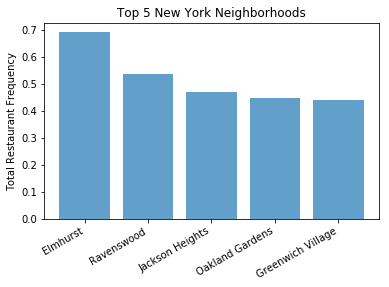

In [182]:
import matplotlib.pyplot as plt
plt.bar(df_ny5['Neighborhood'],df_ny5['Total_Restaurant_Frequency'], align='center', alpha=0.7)
plt.ylabel('Total Restaurant Frequency')
plt.title('Top 5 New York Neighborhoods')
fig = plt.figure(1, [20, 8])
fig.autofmt_xdate()
plt.show()

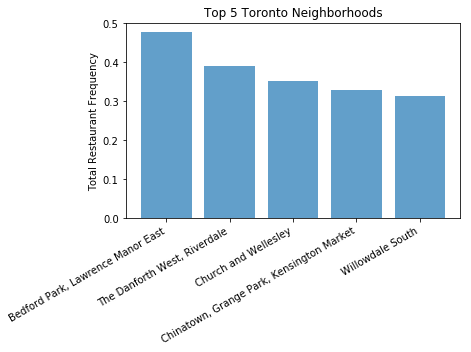

In [181]:
plt.bar(df_tor5['Neighborhood'],df_tor5['Total_Restaurant_Frequency'], align='center', alpha=0.7)
plt.ylabel('Total Restaurant Frequency')
plt.title('Top 5 Toronto Neighborhoods')
fig = plt.figure(1, [20, 8])
fig.autofmt_xdate()
plt.show()